# Rate of Genomic Mutation in HCMV
KIM Hyejun

In [1]:
import os
import re

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt; plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns

In [3]:
from pycirclize.utils import ColorCycler

# Annotation

In [4]:
GFF_FILE_PATH = '../resources/refs/HCMV_Toledo.gff3'
CONTIG_ID = 'GU937742.2'

gene_to_coords = {}

with open(GFF_FILE_PATH, 'rt') as fIn:
    tmp_coords = []
    for line in fIn:
        if not line.strip():
            continue
        elif line.startswith('#'):
            continue
        else:
            chrom, _, feature, start, end, _, strand, _, info = line.strip().split('\t')
            if feature == 'gene':
                if tmp_coords:
                    gene_to_coords[gene] = (min(tmp_coords), max(tmp_coords), gene_strand)
                    tmp_coords = []
                gene = re.search('ID=gene-(.+?);', info).group(1) # new gene
                gene_strand = strand
            elif feature in ('CDS', 'ncRNA'):
                tmp_coords.append(int(start) - 1) # 1-based to 0-based
                tmp_coords.append(int(end))

In [5]:
gene_to_coords['RNA4.9']

(93977, 98873, '+')

# Mutation File

In [6]:
MUTATION_RATE_DIR = '../data/processed/mutations/'
mutation_rate_file_list = [os.path.join(MUTATION_RATE_DIR, f) for f in os.listdir(MUTATION_RATE_DIR) if f.endswith('.txt')]

In [7]:
mutation_rate_file_list

['../data/processed/mutations/Casette_mutation_rates.txt',
 '../data/processed/mutations/delCLIP_mutation_rates.txt',
 '../data/processed/mutations/delNucFoci_mutation_rates.txt',
 '../data/processed/mutations/OriLyt_mutation_rates.txt',
 '../data/processed/mutations/WT_mutation_rates.txt']

In [8]:
sample_to_file_path = {
    os.path.basename(f).split('_')[0]: f for f in mutation_rate_file_list
}
sample_to_file_path

{'Casette': '../data/processed/mutations/Casette_mutation_rates.txt',
 'delCLIP': '../data/processed/mutations/delCLIP_mutation_rates.txt',
 'delNucFoci': '../data/processed/mutations/delNucFoci_mutation_rates.txt',
 'OriLyt': '../data/processed/mutations/OriLyt_mutation_rates.txt',
 'WT': '../data/processed/mutations/WT_mutation_rates.txt'}

In [9]:
file_id_to_label = {
    'Casette': 'del_1.9-4.9k_rpsL',
    'delCLIP': 'del_RNA4.9_hairpin',
    'delNucFoci': 'del_3-4kb',
    'OriLyt': 'del_1.9-4.9k',
    'WT': 'WT'
}

In [12]:
file_id_to_label = {
    'Casette': 'OriLyt + Selection Casette',
    'delCLIP': 'ΔCLIP region',
    'delNucFoci': 'Δ3-4kb',
    'OriLyt': 'OriLyt',
    'WT': 'WT'
}

In [13]:
sample_to_table = {
    file_id_to_label[sample]: pd.read_table(file_path, index_col=0) for sample, file_path in sample_to_file_path.items()
}
print(sample_to_table.keys())
sample_to_table['WT']

dict_keys(['OriLyt + Selection Casette', 'ΔCLIP region', 'Δ3-4kb', 'OriLyt', 'WT'])


,reference_base,reference_matches,A,C,G,T,insertion,deletion,total_coverage,A_rate,C_rate,G_rate,T_rate,insertion_rate,deletion_rate,reference_rate
1,C,7581,0,0,0,0,0,0,7581,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000
2,C,7925,0,0,0,0,0,0,7925,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000
3,A,7747,0,10,0,0,0,0,7757,0.000000,0.001289,0.000000,0.000000,0.0,0.0,0.998711
4,T,7814,0,1,1,0,0,0,7816,0.000000,0.000128,0.000128,0.000000,0.0,0.0,0.999744
5,T,7857,1,2,0,0,0,0,7860,0.000127,0.000254,0.000000,0.000000,0.0,0.0,0.999618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235400,G,1758,0,0,0,0,0,0,1758,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000
235401,G,1711,0,0,0,1,0,0,1712,0.000000,0.000000,0.000000,0.000584,0.0,0.0,0.999416
235402,G,1630,0,0,0,0,0,0,1630,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000
235403,C,1623,0,0,0,0,0,0,1623,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000


In [13]:
for sample, table in sample_to_table.items():
    table.to_csv(f'../data/results/{sample}.basewise_mutation_rate.txt', sep='\t')

이 아래로 파일 이름 잘 보기

# Mutation rate

In [14]:
reference_rates = pd.DataFrame(index=range(1, sample_to_table['WT'].index.to_numpy().max() + 1), columns=[])

for sample, table in sample_to_table.items():
    table = table[table['total_coverage'] > 150]
    reference_rates[sample] = table['reference_matches'] / table[['insertion', 'deletion', 'total_coverage']].sum(axis=1)

reference_rates = reference_rates[['WT', 'OriLyt + Selection Casette', 'OriLyt', 'Δ3-4kb', 'ΔCLIP region']].copy()

reference_rates.fillna(0, inplace=True)
reference_rates

,WT,OriLyt + Selection Casette,OriLyt,Δ3-4kb,ΔCLIP region
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.998711,0.999096,0.999101,0.998444,0.999098
4,0.999744,0.999616,0.999489,0.999872,0.999744
5,0.999618,0.999746,0.998982,0.999744,0.999873
...,...,...,...,...,...
235400,1.000000,0.999553,1.000000,1.000000,1.000000
235401,0.999416,1.000000,0.998966,1.000000,1.000000
235402,1.000000,1.000000,1.000000,1.000000,1.000000
235403,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
reference_rates['position'] = reference_rates.index
reference_rates['window'] = reference_rates['position'] // 1
reference_rates = reference_rates.groupby('window').agg({sample: 'min' for sample in reference_rates.columns if sample != 'position'})
del reference_rates['window']
reference_rates

,WT,OriLyt + Selection Casette,OriLyt,Δ3-4kb,ΔCLIP region
window,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.998711,0.999096,0.999101,0.998444,0.999098
4,0.999744,0.999616,0.999489,0.999872,0.999744
5,0.999618,0.999746,0.998982,0.999744,0.999873
...,...,...,...,...,...
235400,1.000000,0.999553,1.000000,1.000000,1.000000
235401,0.999416,1.000000,0.998966,1.000000,1.000000
235402,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
reference_rates[reference_rates.isna().any(axis=1)]

,WT,OriLyt + Selection Casette,OriLyt,Δ3-4kb,ΔCLIP region
window,,,,,


# Coverage

In [17]:
coverages = pd.DataFrame(index=range(1, sample_to_table['WT'].index.to_numpy().max() + 1), columns=[])

for sample, table in sample_to_table.items():
    table = table[table['total_coverage'] > 10]
    coverages[sample] = table['total_coverage']

coverages = coverages[['WT', 'OriLyt + Selection Casette', 'OriLyt', 'Δ3-4kb', 'ΔCLIP region']].copy()

coverages.fillna(0, inplace=True)
coverages = coverages.astype(int)
coverages

,WT,OriLyt + Selection Casette,OriLyt,Δ3-4kb,ΔCLIP region
1,7581,7493,7571,7581,7634
2,7925,7920,7920,7932,7945
3,7757,7740,7790,7711,7757
4,7816,7821,7823,7804,7808
5,7860,7869,7857,7827,7861
...,...,...,...,...,...
235400,1758,2239,1982,2346,1569
235401,1712,2178,1934,2314,1504
235402,1630,2092,1852,2220,1426
235403,1623,2110,1848,2236,1381


In [18]:
coverages[(coverages > 150).any(axis=1)]

,WT,OriLyt + Selection Casette,OriLyt,Δ3-4kb,ΔCLIP region
1,7581,7493,7571,7581,7634
2,7925,7920,7920,7932,7945
3,7757,7740,7790,7711,7757
4,7816,7821,7823,7804,7808
5,7860,7869,7857,7827,7861
...,...,...,...,...,...
235399,1800,2286,2056,2390,1615
235400,1758,2239,1982,2346,1569
235401,1712,2178,1934,2314,1504
235402,1630,2092,1852,2220,1426


In [19]:
(coverages > 150)

,WT,OriLyt + Selection Casette,OriLyt,Δ3-4kb,ΔCLIP region
1,True,True,True,True,True
2,True,True,True,True,True
3,True,True,True,True,True
4,True,True,True,True,True
5,True,True,True,True,True
...,...,...,...,...,...
235400,True,True,True,True,True
235401,True,True,True,True,True
235402,True,True,True,True,True
235403,True,True,True,True,True


In [20]:
xs = coverages[(coverages <= 150).any(axis=1)].index.to_list()

merged_regions = []
start = None
end = None

for i in range(len(xs)):
    if start is None:
        start = xs[i]
        end = xs[i]
    elif xs[i] == end + 1:
        end = xs[i]
    else:
        merged_regions.append((start, end))
        start = xs[i]
        end = xs[i]

# Append the last region
if start is not None:
    merged_regions.append((start, end))

In [21]:
merged_regions

[(95822, 98824), (199522, 206004), (235404, 235404)]

# Plot

In [22]:
(coverages > 150).T == False

,1,2,3,4,5,6,7,8,9,10,...,235395,235396,235397,235398,235399,235400,235401,235402,235403,235404
WT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
OriLyt + Selection Casette,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
OriLyt,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
Δ3-4kb,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
ΔCLIP region,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


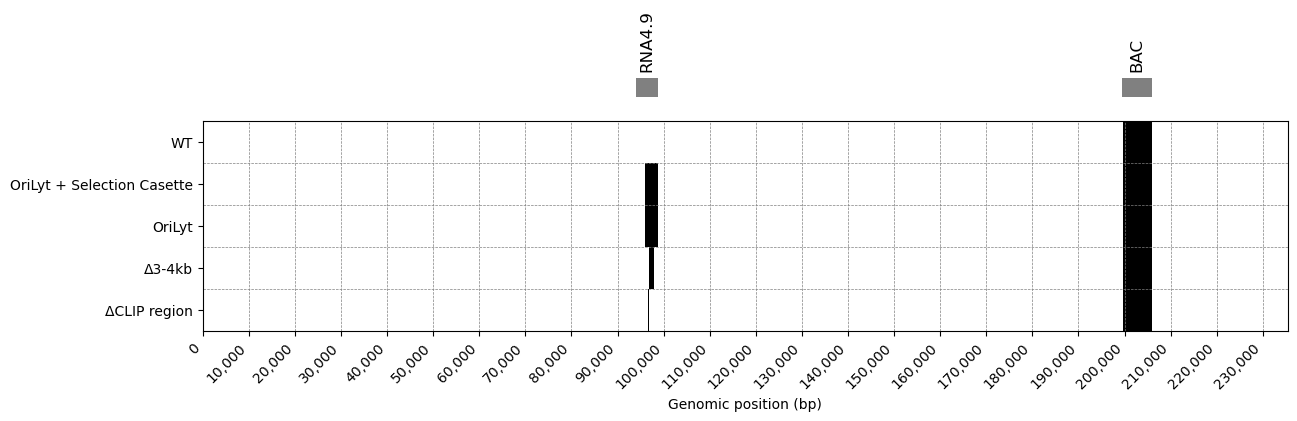

In [23]:
df = (coverages > 150)

plt.style.use('default')

fig, axes = plt.subplots(2, 1, figsize=(14, 3.3), gridspec_kw={'height_ratios': [1, 10]}, sharex=True)

ax = axes[1]
anno = axes[0]

ax.imshow(df.T, aspect='auto', interpolation='none', cmap='Greys_r', rasterized=True)

ax.set_yticks(range(len(df.columns)), df.columns)
xticks = range(0, len(df), 10000)
ax.set_xticks(xticks)
ax.set_xticks(
    ticks=xticks,
    labels=[f'{x:,}' for x in xticks],
    rotation=45, ha='right'
)
ax.set_xlabel('Genomic position (bp)')
anno.set_yticklabels([])

for gene_name, (start, end, strand) in gene_to_coords.items():
    if gene_name.startswith('RNA4.9') and (start < len(df)):
        anno.fill_between([start + 1, end], 0, 1, color='gray', ec='None')
        anno.text((start + 1 + end) / 2, 1.5, gene_name, color='black', fontsize=12, ha='center', rotation=90)

for i, (start, end) in enumerate(merged_regions):
    if i == 1:
        anno.fill_between([start + 1, end], 0, 1, color='gray', ec='None')
        anno.text((start + 1 + end) / 2, 1.5, 'BAC', color='black', fontsize=12, ha='center', rotation=90)

anno.spines['left'].set_visible(False)
anno.spines['right'].set_visible(False)
anno.spines['top'].set_visible(False)
anno.spines['bottom'].set_visible(False)

anno.tick_params(axis='y', left=False, right=False, labelleft=False)
anno.tick_params(axis='x', bottom=False, top=False, labelbottom=False)

# Add gridlines
for i in range(len(df.columns)):
    ax.axhline(i - 0.5, color='grey', linestyle='--', linewidth=0.5)
for j in range(0, len(df), 10000):
    ax.axvline(j - 0.5, color='grey', linestyle='--', linewidth=0.5)

# plt.savefig('../data/results/deleted-region.pdf', bbox_inches='tight')
# plt.savefig('../data/results/deleted-region.png', bbox_inches='tight')

In [24]:
reference_rates

,WT,OriLyt + Selection Casette,OriLyt,Δ3-4kb,ΔCLIP region
window,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.998711,0.999096,0.999101,0.998444,0.999098
4,0.999744,0.999616,0.999489,0.999872,0.999744
5,0.999618,0.999746,0.998982,0.999744,0.999873
...,...,...,...,...,...
235400,1.000000,0.999553,1.000000,1.000000,1.000000
235401,0.999416,1.000000,0.998966,1.000000,1.000000
235402,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
(coverages < 150)['OriLyt']

1         False
2         False
3         False
4         False
5         False
          ...  
235400    False
235401    False
235402    False
235403    False
235404     True
Name: OriLyt, Length: 235404, dtype: bool

In [52]:
label_to_print = {
    'OriLyt + Selection Casette': r'1.9-4.9k$^{rpsL}$',
    'ΔCLIP region': r'ΔRNA4.9$^{Hairpins}$',
    'Δ3-4kb': r'Δ3.0-4.0k',
    'OriLyt': r'Δ1.9-4.9k',
    'WT': 'WT'
}

['WT', 'OriLyt + Selection Casette', 'OriLyt', 'Δ3-4kb', 'ΔCLIP region']


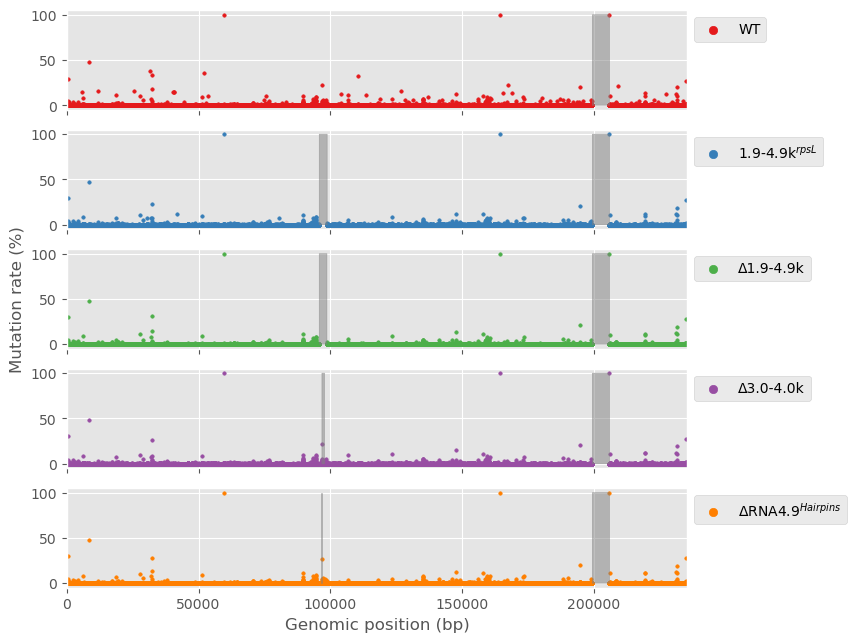

In [53]:
plt.style.use('ggplot')

ColorCycler.set_cmap('Set1')

eps = 1
df = 100.0 - reference_rates.copy() * 100
mask = (coverages <= 150).copy()
df[mask] = np.nan

print(list(df.columns))

fig, axes = plt.subplots(5, 1, figsize=(8, 7.5), sharex=True)

# fig.suptitle('HCMV Toledo (GU937742.2)')

for i, sample in enumerate(df.columns):
    color=ColorCycler()
    axes[i].scatter(df.index, df[sample], s=6, c=color)
    axes[i].scatter([], [], s=36, c=color, label=label_to_print[sample])
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    # mask
    axes[i].fill_between(mask.index, 0, 100, where=mask[sample], color='grey', alpha=0.5)
    axes[i].set_xlim(0, len(df))

axes[len(axes) // 2].set_ylabel('Mutation rate (%)')
axes[-1].set_xlabel('Genomic position (bp)')

plt.savefig('../data/results/mutation_rate_per_base.png', dpi=300, bbox_inches='tight')
plt.savefig('../data/results/mutation_rate_per_base.jpg', dpi=300, bbox_inches='tight')
plt.savefig('../data/results/mutation_rate_per_base.pdf', dpi=300, bbox_inches='tight')

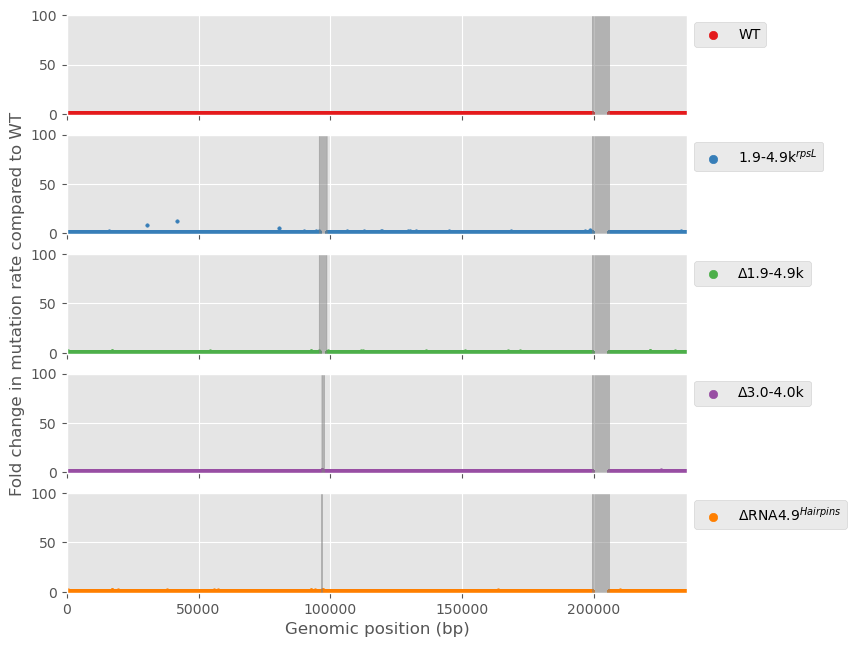

In [54]:
plt.style.use('ggplot')

ColorCycler.set_cmap('Set1')

eps = 1
df = 100.0 - reference_rates.copy() * 100
mask = (coverages <= 150).copy()
df[mask] = np.nan

df = np.log(df + eps).sub(np.log(df['WT'] + eps), axis=0)
df = np.exp(df)
# line plot
fig, axes = plt.subplots(5, 1, figsize=(8, 7.5), sharex=True)
for i, sample in enumerate(['WT', 'OriLyt + Selection Casette', 'OriLyt', 'Δ3-4kb', 'ΔCLIP region']):
    color=ColorCycler()
    axes[i].scatter(df.index, df[sample], s=6, c=color)
    axes[i].scatter([], [], s=36, c=color, label=label_to_print[sample])
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    # mask
    axes[i].fill_between(mask.index, -1, 100, where=mask[sample], color='grey', alpha=0.5)
    axes[i].set_xlim(0, len(df))
    axes[i].set_ylim(-1, 100)
axes[len(axes) // 2].set_ylabel('Fold change in mutation rate compared to WT')
axes[-1].set_xlabel('Genomic position (bp)')

plt.savefig('../data/results/mutation_rate_per_base_fold_change.jpg', dpi=300, bbox_inches='tight')
plt.savefig('../data/results/mutation_rate_per_base_fold_change.png', dpi=300, bbox_inches='tight')
plt.savefig('../data/results/mutation_rate_per_base_fold_change.pdf', dpi=300, bbox_inches='tight')